# Clasificación de Sonidos Ambientales con ResNet-50
## Práctica: Dataset ESC-50 + Transfer Learning

### Objetivo
Clasificar sonidos ambientales del dataset ESC-50 utilizando el modelo ResNet-50 pre-entrenado en ImageNet.

### ¿Por qué funciona esto?
ResNet-50 está diseñado para clasificar imágenes, pero los sonidos pueden convertirse en **espectrogramas** (representaciones visuales del audio). Así, aprovechamos el conocimiento que ResNet-50 aprendió de millones de imágenes para clasificar sonidos.

### Flujo del proyecto:
1. **Cargar** el dataset ESC-50 (ya descargado en data/ESC-50-master)
2. **Convertir** audios a espectrogramas (imágenes)
3. **Adaptar** ResNet-50 para 50 clases de sonidos
4. **Entrenar** el modelo
5. **Evaluar** los resultados

---
## 1. Instalación de Dependencias

Primero instalamos las librerías necesarias si no las tienes.

In [1]:
# ============================================================
# INSTALACIÓN DE DEPENDENCIAS
# ============================================================
# Ejecuta esta celda solo si te falta alguna librería
#
# - torch y torchvision: Framework de deep learning de PyTorch
# - torchaudio: Procesamiento de audio con PyTorch
# - librosa: Librería especializada en análisis de audio
# - matplotlib: Para crear gráficos y visualizaciones
# - pandas: Manipulación de datos tabulares
# - tqdm: Barras de progreso bonitas
# - scikit-learn: Métricas y utilidades de ML

!pip install torch torchvision torchaudio librosa matplotlib pandas tqdm scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


---
## 2. Importación de Librerías

In [2]:
# ============================================================
# IMPORTACIONES PRINCIPALES
# ============================================================

# --- Librerías estándar de Python ---
import os                    # Operaciones con el sistema de archivos (rutas, directorios)
import warnings              # Para controlar mensajes de advertencia
warnings.filterwarnings('ignore')  # Silenciamos advertencias molestas

# --- Librerías de datos ---
import numpy as np           # Operaciones numéricas con arrays (vectores y matrices)
import pandas as pd          # Manipulación de datos en formato tabla (DataFrames)

# --- Librerías de audio ---
import librosa               # Análisis y procesamiento de audio
import librosa.display       # Visualización de espectrogramas

# --- Librerías de visualización ---
import matplotlib.pyplot as plt  # Crear gráficos

# --- PyTorch: Framework de Deep Learning ---
import torch                            # Librería principal de PyTorch
import torch.nn as nn                   # Módulos de redes neuronales (capas, funciones)
import torch.optim as optim             # Optimizadores (SGD, Adam, etc.)
from torch.utils.data import Dataset, DataLoader  # Clases para manejar datos

# --- TorchVision: Modelos y transformaciones de imágenes ---
import torchvision.models as models     # Modelos pre-entrenados (ResNet, VGG, etc.)
import torchvision.transforms as transforms  # Transformaciones de imágenes

# --- Utilidades ---
from tqdm import tqdm                   # Barras de progreso
from sklearn.metrics import confusion_matrix, classification_report  # Métricas

print("✅ Todas las librerías importadas correctamente")

✅ Todas las librerías importadas correctamente


In [3]:
# ============================================================
# CONFIGURACIÓN DEL DISPOSITIVO (GPU/CPU)
# ============================================================

# PyTorch puede usar GPU (CUDA) para acelerar el entrenamiento
# Si tienes GPU NVIDIA compatible, usará CUDA; si no, usará CPU

# torch.cuda.is_available() devuelve True si hay GPU NVIDIA disponible
if torch.cuda.is_available():
    device = torch.device('cuda')       # Usar GPU
    gpu_name = torch.cuda.get_device_name(0)  # Nombre de la GPU
    print(f"🎮 GPU detectada: {gpu_name}")
else:
    device = torch.device('cpu')        # Usar CPU
    print("💻 No se detectó GPU. Usando CPU (será más lento)")

print(f"\n🖥️  Dispositivo seleccionado: {device}")
print(f"📦 PyTorch versión: {torch.__version__}")

🎮 GPU detectada: NVIDIA RTX A4000 Laptop GPU

🖥️  Dispositivo seleccionado: cuda
📦 PyTorch versión: 2.6.0+cu124


---
## 3. Configuración de Rutas del Dataset

### Dataset ESC-50 (ya descargado)
El dataset está en `data/ESC-50-master/` y contiene:
- **2000 grabaciones** de audio de 5 segundos cada una
- **50 clases** de sonidos ambientales (perro, lluvia, reloj, etc.)
- **40 clips por clase**
- Organizado en **5 folds** para validación cruzada

In [4]:
# ============================================================
# CONFIGURACIÓN DE RUTAS
# ============================================================

# Ruta al dataset ESC-50 (ya descargado previamente con git clone)
DATASET_PATH = "data/ESC-50-master"

# Ruta a la carpeta de audios (contiene los 2000 archivos .wav)
AUDIO_DIR = os.path.join(DATASET_PATH, "audio")

# Ruta a la carpeta de espectrogramas pre-computados
SPECTROGRAM_DIR = os.path.join(DATASET_PATH, "audio_image")

# Ruta al archivo de metadatos (CSV con información de cada audio)
META_PATH = os.path.join(DATASET_PATH, "meta", "esc50.csv")

# ============================================================
# CONFIGURACIÓN DEL MODO DE ESPECTROGRAMAS
# ============================================================
# True  = Cargar espectrogramas pre-computados desde SPECTROGRAM_DIR (más rápido)
# False = Calcular espectrogramas al vuelo desde audio (más flexible)
USAR_ESPECTROGRAMAS_PRECOMPUTADOS = True

# Verificamos que las rutas existan
print("📁 VERIFICACIÓN DE RUTAS:")
print("="*50)

# os.path.exists() comprueba si una ruta existe
if os.path.exists(DATASET_PATH):
    print(f"✅ Dataset encontrado: {DATASET_PATH}")
else:
    print(f"❌ ERROR: No se encontró el dataset en {DATASET_PATH}")
    print("   Ejecuta: git clone https://github.com/karolpiczak/ESC-50.git data/ESC-50-master")

if os.path.exists(AUDIO_DIR):
    # os.listdir() lista los archivos en un directorio
    num_audios = len([f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')])
    print(f"✅ Carpeta de audio: {num_audios} archivos .wav")
else:
    print(f"❌ ERROR: No se encontró la carpeta de audio")

if os.path.exists(META_PATH):
    print(f"✅ Archivo de metadatos encontrado")
else:
    print(f"❌ ERROR: No se encontró el archivo de metadatos")

# Verificar espectrogramas pre-computados
if USAR_ESPECTROGRAMAS_PRECOMPUTADOS:
    if os.path.exists(SPECTROGRAM_DIR):
        num_specs = len([f for f in os.listdir(SPECTROGRAM_DIR) if f.endswith('.npy')])
        print(f"✅ Carpeta de espectrogramas: {num_specs} archivos .npy")
        if num_specs == 0:
            print("   ⚠️  La carpeta existe pero está vacía. Ejecuta la celda de pre-computación.")
    else:
        print(f"⚠️  Carpeta de espectrogramas no encontrada: {SPECTROGRAM_DIR}")
        print("   Ejecuta la celda de pre-computación o cambia USAR_ESPECTROGRAMAS_PRECOMPUTADOS = False")

print(f"\n🔧 Modo actual: {'Espectrogramas PRE-COMPUTADOS' if USAR_ESPECTROGRAMAS_PRECOMPUTADOS else 'Cálculo AL VUELO'}")

📁 VERIFICACIÓN DE RUTAS:
✅ Dataset encontrado: data/ESC-50-master
✅ Carpeta de audio: 2000 archivos .wav
✅ Archivo de metadatos encontrado
✅ Carpeta de espectrogramas: 2000 archivos .npy

🔧 Modo actual: Espectrogramas PRE-COMPUTADOS


---
## 4. Exploración del Dataset (EDA)

Antes de entrenar, es fundamental **entender nuestros datos**.

In [5]:
# ============================================================
# CARGA DE METADATOS
# ============================================================

# pd.read_csv() lee un archivo CSV y lo convierte en DataFrame
# Un DataFrame es como una tabla de Excel en Python
df = pd.read_csv(META_PATH)

# Mostramos las primeras 5 filas para ver la estructura
print("📋 ESTRUCTURA DEL DATASET:")
print("="*60)
print("\nPrimeras 5 filas del archivo de metadatos:")
df.head()

📋 ESTRUCTURA DEL DATASET:

Primeras 5 filas del archivo de metadatos:


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
# ============================================================
# EXPLICACIÓN DE LAS COLUMNAS
# ============================================================

print("📖 SIGNIFICADO DE CADA COLUMNA:")
print("="*60)
print("""
• filename   : Nombre del archivo de audio (ej: "1-100032-A-0.wav")
• fold       : Número de fold (1-5) para validación cruzada
• target     : ID numérico de la categoría (0-49)
• category   : Nombre de la categoría (ej: "dog", "rain")
• esc10      : Si pertenece al subconjunto ESC-10 (True/False)
• src_file   : ID del archivo fuente original de Freesound
• take       : Número de toma (A, B, C...) del mismo audio fuente
""")

📖 SIGNIFICADO DE CADA COLUMNA:

• filename   : Nombre del archivo de audio (ej: "1-100032-A-0.wav")
• fold       : Número de fold (1-5) para validación cruzada
• target     : ID numérico de la categoría (0-49)
• category   : Nombre de la categoría (ej: "dog", "rain")
• esc10      : Si pertenece al subconjunto ESC-10 (True/False)
• src_file   : ID del archivo fuente original de Freesound
• take       : Número de toma (A, B, C...) del mismo audio fuente



In [7]:
# ============================================================
# ANÁLISIS ESTADÍSTICO DEL DATASET
# ============================================================

print("📊 ESTADÍSTICAS DEL DATASET ESC-50")
print("="*60)

# .shape nos da (filas, columnas) del DataFrame
print(f"\n📁 Total de archivos de audio: {df.shape[0]}")

# .nunique() cuenta valores únicos en una columna
print(f"🏷️  Número de categorías: {df['category'].nunique()}")

# Número de folds (para validación cruzada)
print(f"📂 Número de folds: {df['fold'].nunique()}")

# Verificamos que el dataset esté balanceado
print(f"\n🔢 Distribución por categoría:")
# value_counts() cuenta ocurrencias de cada valor único
conteo = df['category'].value_counts()
print(f"   - Mínimo por categoría: {conteo.min()} audios")
print(f"   - Máximo por categoría: {conteo.max()} audios")

print("\n✅ Dataset perfectamente balanceado: 40 muestras por categoría")

📊 ESTADÍSTICAS DEL DATASET ESC-50

📁 Total de archivos de audio: 2000
🏷️  Número de categorías: 50
📂 Número de folds: 5

🔢 Distribución por categoría:
   - Mínimo por categoría: 40 audios
   - Máximo por categoría: 40 audios

✅ Dataset perfectamente balanceado: 40 muestras por categoría


In [8]:
# ============================================================
# LISTADO DE TODAS LAS CATEGORÍAS
# ============================================================

print("🏷️  LAS 50 CATEGORÍAS DEL DATASET ESC-50:")
print("="*60)

# .unique() devuelve un array con los valores únicos
# sorted() los ordena alfabéticamente
categorias = sorted(df['category'].unique())

# Mostramos las categorías en formato de tabla (3 columnas)
for i, cat in enumerate(categorias, 1):
    print(f"{i:2d}. {cat.ljust(20)}", end='')
    if i % 3 == 0:
        print()

🏷️  LAS 50 CATEGORÍAS DEL DATASET ESC-50:
 1. airplane             2. breathing            3. brushing_teeth      
 4. can_opening          5. car_horn             6. cat                 
 7. chainsaw             8. chirping_birds       9. church_bells        
10. clapping            11. clock_alarm         12. clock_tick          
13. coughing            14. cow                 15. crackling_fire      
16. crickets            17. crow                18. crying_baby         
19. dog                 20. door_wood_creaks    21. door_wood_knock     
22. drinking_sipping    23. engine              24. fireworks           
25. footsteps           26. frog                27. glass_breaking      
28. hand_saw            29. helicopter          30. hen                 
31. insects             32. keyboard_typing     33. laughing            
34. mouse_click         35. pig                 36. pouring_water       
37. rain                38. rooster             39. sea_waves           
40. sheep

🎵 Analizando audio de ejemplo:
   Archivo: 1-100032-A-0.wav
   Categoría: dog

📊 Propiedades del audio:
   - Sample rate: 44100 Hz (muestras por segundo)
   - Duración: 5.00 segundos
   - Total de muestras: 220,500


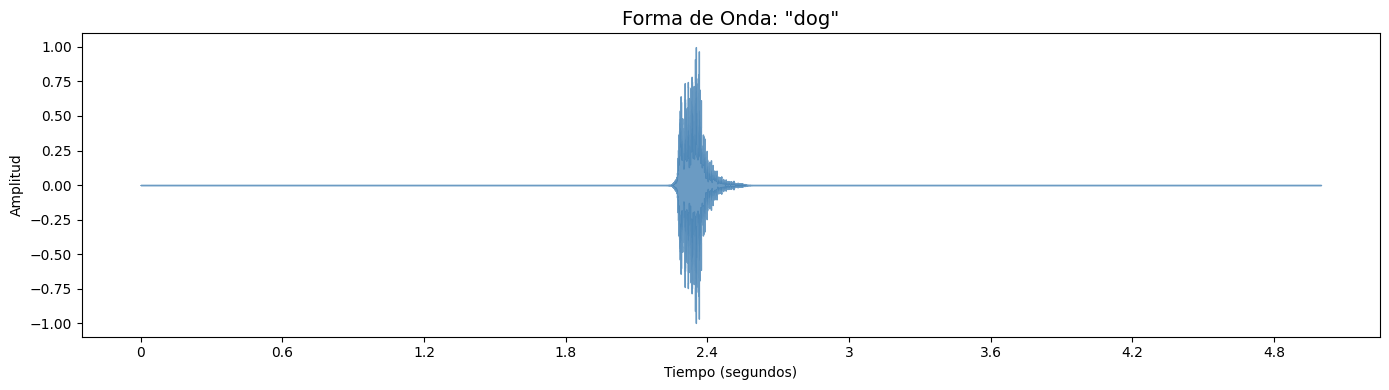

In [9]:
# ============================================================
# VISUALIZACIÓN DE UNA FORMA DE ONDA
# ============================================================

# Tomamos un archivo de ejemplo (el primero del DataFrame)
ejemplo_archivo = df.iloc[0]['filename']  # iloc[0] = primera fila
ejemplo_categoria = df.iloc[0]['category']
ejemplo_path = os.path.join(AUDIO_DIR, ejemplo_archivo)

print(f"🎵 Analizando audio de ejemplo:")
print(f"   Archivo: {ejemplo_archivo}")
print(f"   Categoría: {ejemplo_categoria}")

# librosa.load() carga un archivo de audio
# Retorna:
#   - y: numpy array con los valores de amplitud de la onda
#   - sr: sample rate (muestras por segundo)
y, sr = librosa.load(ejemplo_path, sr=None)  # sr=None mantiene el sample rate original

print(f"\n📊 Propiedades del audio:")
print(f"   - Sample rate: {sr} Hz (muestras por segundo)")
print(f"   - Duración: {len(y)/sr:.2f} segundos")
print(f"   - Total de muestras: {len(y):,}")

# Creamos una figura para visualizar la forma de onda
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.8, color='steelblue')
plt.title(f'Forma de Onda: "{ejemplo_categoria}"', fontsize=14)
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.show()

---
## 5. Conversión de Audio a Espectrogramas

### ¿Qué es un espectrograma?
Un **espectrograma** es una representación visual del audio que muestra:
- **Eje X**: Tiempo
- **Eje Y**: Frecuencia (Hz)
- **Color**: Intensidad/Energía

### ¿Por qué Mel-Espectrogramas?
La escala **Mel** imita cómo el oído humano percibe frecuencias:
- Somos más sensibles a diferencias en frecuencias bajas
- La escala Mel compensa esto

### Esto es la clave del proyecto:
ResNet-50 espera **imágenes**. Al convertir audio → espectrograma, transformamos el problema de clasificación de audio en un problema de clasificación de imágenes.

In [10]:
# ============================================================
# FUNCIÓN PARA CREAR MEL-ESPECTROGRAMAS
# ============================================================

def audio_a_mel_espectrograma(ruta_audio, sr=22050, n_mels=128, duracion_fija=5.0):
    """
    Convierte un archivo de audio en un Mel-espectrograma.
    
    Parámetros:
    -----------
    ruta_audio : str
        Ruta al archivo de audio (.wav)
    
    sr : int (default=22050)
        Sample rate deseado. 22050 Hz es estándar.
    
    n_mels : int (default=128)
        Número de bandas Mel. Más bandas = más detalle.
    
    duracion_fija : float (default=5.0)
        Duración en segundos. ESC-50 tiene audios de 5 segundos.
    
    Retorna:
    --------
    numpy.ndarray
        Mel-espectrograma en escala de decibelios (dB)
    """
    
    # --- Paso 1: Cargar el audio ---
    # librosa.load carga el audio y lo remuestrea al sr especificado
    y, sr = librosa.load(ruta_audio, sr=sr, duration=duracion_fija)
    
    # --- Paso 2: Asegurar longitud fija ---
    # Calculamos cuántas muestras necesitamos para 5 segundos
    longitud_objetivo = int(sr * duracion_fija)
    
    # Si el audio es más corto, rellenamos con ceros (silencio)
    if len(y) < longitud_objetivo:
        padding = longitud_objetivo - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    else:
        y = y[:longitud_objetivo]
    
    # --- Paso 3: Calcular el Mel-espectrograma ---
    mel_spec = librosa.feature.melspectrogram(
        y=y,              # Señal de audio
        sr=sr,            # Sample rate
        n_mels=n_mels,    # Bandas Mel
        n_fft=2048,       # Tamaño ventana FFT
        hop_length=512    # Salto entre ventanas
    )
    
    # --- Paso 4: Convertir a escala de decibelios ---
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

print("✅ Función audio_a_mel_espectrograma() definida")

✅ Función audio_a_mel_espectrograma() definida


🎨 Generando Mel-espectrogramas de ejemplo...


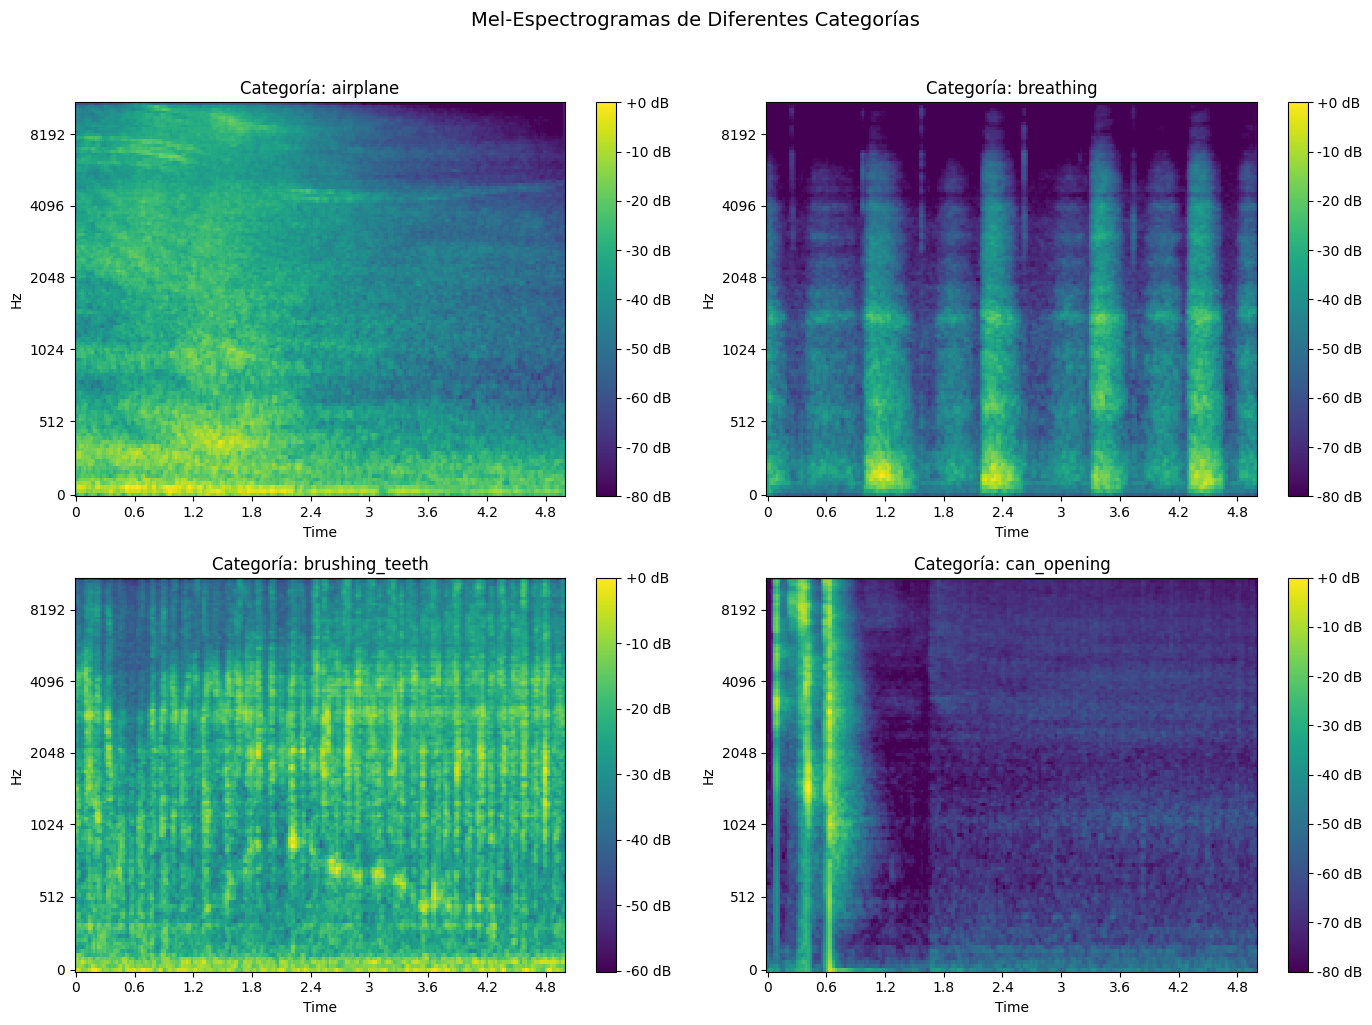


💡 Cada tipo de sonido tiene un 'patrón visual' único.
   ResNet-50 aprenderá a reconocer estos patrones.


In [11]:
# ============================================================
# VISUALIZACIÓN DE MEL-ESPECTROGRAMAS
# ============================================================

# Seleccionamos 4 ejemplos de diferentes categorías
ejemplos = df.groupby('category').first().reset_index().head(4)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

print("🎨 Generando Mel-espectrogramas de ejemplo...")

for idx, (_, fila) in enumerate(ejemplos.iterrows()):
    ruta = os.path.join(AUDIO_DIR, fila['filename'])
    categoria = fila['category']
    
    mel_spec = audio_a_mel_espectrograma(ruta)
    
    img = librosa.display.specshow(
        mel_spec,
        x_axis='time',
        y_axis='mel',
        sr=22050,
        hop_length=512,
        ax=axes[idx],
        cmap='viridis'
    )
    
    axes[idx].set_title(f'Categoría: {categoria}', fontsize=12)
    fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')

plt.suptitle('Mel-Espectrogramas de Diferentes Categorías', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Cada tipo de sonido tiene un 'patrón visual' único.")
print("   ResNet-50 aprenderá a reconocer estos patrones.")

In [12]:
# ============================================================
# PRE-COMPUTAR Y GUARDAR ESPECTROGRAMAS (EJECUTAR UNA VEZ)
# ============================================================
# Esta celda genera todos los espectrogramas y los guarda en disco.
# Solo necesitas ejecutarla UNA VEZ. Después puedes saltar esta celda.
#
# Ventajas de pre-computar:
#   - Entrenamiento mucho más rápido (no recalcula cada época)
#   - Permite usar más workers en el DataLoader
#
# Los espectrogramas se guardan como archivos .npy (NumPy arrays)
# para preservar la precisión numérica completa.

def precomputar_espectrogramas(df, audio_dir, output_dir, sr=22050, n_mels=128, duracion_fija=5.0):
    """
    Pre-computa y guarda todos los espectrogramas del dataset.
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con la columna 'filename'
    audio_dir : str
        Directorio con los archivos de audio
    output_dir : str
        Directorio donde guardar los espectrogramas
    """
    import os
    
    # Crear directorio si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"📂 Guardando espectrogramas en: {output_dir}")
    print(f"📊 Total de archivos a procesar: {len(df)}")
    print("="*50)
    
    archivos_creados = 0
    archivos_existentes = 0
    
    for idx, fila in tqdm(df.iterrows(), total=len(df), desc="Procesando"):
        filename = fila['filename']
        ruta_audio = os.path.join(audio_dir, filename)
        
        # Nombre del archivo de salida (.wav -> .npy)
        nombre_spec = filename.replace('.wav', '.npy')
        ruta_spec = os.path.join(output_dir, nombre_spec)
        
        # Si ya existe, saltar
        if os.path.exists(ruta_spec):
            archivos_existentes += 1
            continue
        
        # Calcular espectrograma
        mel_spec = audio_a_mel_espectrograma(ruta_audio, sr=sr, n_mels=n_mels, duracion_fija=duracion_fija)
        
        # Guardar como archivo NumPy
        np.save(ruta_spec, mel_spec)
        archivos_creados += 1
    
    print("\n" + "="*50)
    print(f"✅ Pre-computación completada:")
    print(f"   - Archivos creados: {archivos_creados}")
    print(f"   - Archivos ya existentes (saltados): {archivos_existentes}")
    print(f"   - Total en directorio: {len(os.listdir(output_dir))}")
    
    # Calcular tamaño total
    tamano_total = sum(os.path.getsize(os.path.join(output_dir, f)) 
                       for f in os.listdir(output_dir) if f.endswith('.npy'))
    print(f"   - Tamaño total: {tamano_total / (1024*1024):.2f} MB")

# Ejecutar pre-computación (solo si no existen o están incompletos)
if USAR_ESPECTROGRAMAS_PRECOMPUTADOS:
    num_existentes = len([f for f in os.listdir(SPECTROGRAM_DIR) if f.endswith('.npy')]) if os.path.exists(SPECTROGRAM_DIR) else 0
    
    if num_existentes < len(df):
        print("🔄 Iniciando pre-computación de espectrogramas...")
        precomputar_espectrogramas(df, AUDIO_DIR, SPECTROGRAM_DIR)
    else:
        print(f"✅ Espectrogramas ya pre-computados ({num_existentes} archivos)")
        print(f"   Ubicación: {SPECTROGRAM_DIR}")
else:
    print("ℹ️  Modo AL VUELO activado. No es necesario pre-computar.")
    print("   Cambia USAR_ESPECTROGRAMAS_PRECOMPUTADOS = True para usar espectrogramas pre-computados.")

✅ Espectrogramas ya pre-computados (2000 archivos)
   Ubicación: data/ESC-50-master\audio_image


In [13]:
# ============================================================
# DATASET PERSONALIZADO PARA ESC-50 (SOPORTA AMBOS MODOS)
# ============================================================

class ESC50Dataset(Dataset):
    """
    Dataset personalizado para ESC-50 que soporta:
    - Modo PRE-COMPUTADO: Carga espectrogramas desde archivos .npy (rápido)
    - Modo AL VUELO: Calcula espectrogramas desde audio (flexible)
    """
    
    def __init__(self, dataframe, audio_dir, spectrogram_dir=None, 
                 usar_precomputados=False, transform=None):
        """
        Inicializa el dataset.
        
        Parámetros:
        -----------
        dataframe : pd.DataFrame
            DataFrame con columnas 'filename' y 'category'
        audio_dir : str
            Directorio con los archivos de audio (.wav)
        spectrogram_dir : str, opcional
            Directorio con espectrogramas pre-computados (.npy)
        usar_precomputados : bool
            Si True, carga desde spectrogram_dir; si False, calcula al vuelo
        transform : callable, opcional
            Transformaciones a aplicar
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.audio_dir = audio_dir
        self.spectrogram_dir = spectrogram_dir
        self.usar_precomputados = usar_precomputados
        self.transform = transform
        
        # Mapeo de categoría a índice numérico
        self.categorias = sorted(dataframe['category'].unique())
        self.categoria_a_idx = {cat: idx for idx, cat in enumerate(self.categorias)}
        
        # Verificar que los espectrogramas existan si se usa modo pre-computado
        if self.usar_precomputados:
            if spectrogram_dir is None:
                raise ValueError("spectrogram_dir es requerido cuando usar_precomputados=True")
            if not os.path.exists(spectrogram_dir):
                raise FileNotFoundError(f"Directorio de espectrogramas no encontrado: {spectrogram_dir}")
    
    def __len__(self):
        """Retorna el número total de muestras."""
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        """
        Obtiene un elemento por su índice.
        
        Retorna:
        --------
        tuple (tensor, int): Espectrograma y etiqueta
        """
        fila = self.dataframe.iloc[idx]
        etiqueta = self.categoria_a_idx[fila['category']]
        
        if self.usar_precomputados:
            # --- MODO PRE-COMPUTADO: Cargar desde archivo .npy ---
            nombre_spec = fila['filename'].replace('.wav', '.npy')
            ruta_spec = os.path.join(self.spectrogram_dir, nombre_spec)
            mel_spec = np.load(ruta_spec)
        else:
            # --- MODO AL VUELO: Calcular desde audio ---
            ruta_audio = os.path.join(self.audio_dir, fila['filename'])
            mel_spec = audio_a_mel_espectrograma(ruta_audio)
        
        # Normalizar al rango [0, 1]
        mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min() + 1e-8)
        
        # Convertir a tensor
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
        
        # Añadir dimensión de canal y replicar a 3 canales (RGB)
        mel_spec = mel_spec.unsqueeze(0).repeat(3, 1, 1)
        
        # Aplicar transformaciones
        if self.transform:
            mel_spec = self.transform(mel_spec)
        
        return mel_spec, etiqueta

print("✅ Clase ESC50Dataset definida")
print(f"   Modo configurado: {'PRE-COMPUTADO' if USAR_ESPECTROGRAMAS_PRECOMPUTADOS else 'AL VUELO'}")

✅ Clase ESC50Dataset definida
   Modo configurado: PRE-COMPUTADO


In [14]:
# ============================================================
# TRANSFORMACIONES PARA LAS IMÁGENES
# ============================================================

# ResNet-50 espera imágenes de 224x224 con normalización de ImageNet
transformaciones = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Normalize(
    #    mean=[0.485, 0.456, 0.406],  # Media de ImageNet
    #    std=[0.229, 0.224, 0.225]    # Desviación estándar de ImageNet
    #)
])

print("✅ Transformaciones definidas:")
print("   1. Resize: (128, 216) → (224, 224)")
#print("   2. Normalize: Estadísticas de ImageNet")

✅ Transformaciones definidas:
   1. Resize: (128, 216) → (224, 224)
   2. Normalize: Estadísticas de ImageNet


In [15]:
# ============================================================
# DIVISIÓN TRAIN / VALIDATION
# ============================================================
# ESC-50 viene pre-organizado en 5 folds para validación cruzada
# Usamos Folds 1-4 para entrenamiento y Fold 5 para validación

# Folds 1-4 → Entrenamiento (1600 muestras)
df_train = df[df['fold'].isin([1, 2, 3, 4])]

# Fold 5 → Validación (400 muestras)
df_val = df[df['fold'] == 5]

print("📊 DIVISIÓN DEL DATASET:")
print("="*50)
print(f"   Train: {len(df_train)} muestras (Folds 1-4)")
print(f"   Val:   {len(df_val)} muestras (Fold 5)")
print(f"   Total: {len(df_train) + len(df_val)} muestras")

📊 DIVISIÓN DEL DATASET:
   Train: 1600 muestras (Folds 1-4)
   Val:   400 muestras (Fold 5)
   Total: 2000 muestras


In [16]:
# ============================================================
# CREACIÓN DE DATASETS Y DATALOADERS
# ============================================================

# Crear datasets con el modo configurado
dataset_train = ESC50Dataset(
    dataframe=df_train, 
    audio_dir=AUDIO_DIR, 
    spectrogram_dir=SPECTROGRAM_DIR,
    usar_precomputados=USAR_ESPECTROGRAMAS_PRECOMPUTADOS,
    transform=transformaciones
)

dataset_val = ESC50Dataset(
    dataframe=df_val, 
    audio_dir=AUDIO_DIR, 
    spectrogram_dir=SPECTROGRAM_DIR,
    usar_precomputados=USAR_ESPECTROGRAMAS_PRECOMPUTADOS,
    transform=transformaciones
)

BATCH_SIZE = 32

# NOTA: En Windows, num_workers > 0 puede causar que el entrenamiento se congele.
# Si tienes problemas, usa NUM_WORKERS = 0
NUM_WORKERS = 0  # Cambia a 2 o 4 en Linux/Mac para mayor velocidad

train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() and NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() and NUM_WORKERS > 0 else False
)

print("✅ DataLoaders creados:")
print(f"   - Modo: {'PRE-COMPUTADO' if USAR_ESPECTROGRAMAS_PRECOMPUTADOS else 'AL VUELO'}")
print(f"   - Train: {len(train_loader)} batches de {BATCH_SIZE}")
print(f"   - Val: {len(val_loader)} batches de {BATCH_SIZE}")
print(f"   - Workers: {NUM_WORKERS}")

✅ DataLoaders creados:
   - Modo: PRE-COMPUTADO
   - Train: 50 batches de 32
   - Val: 13 batches de 32
   - Workers: 0


---
## 7. Configuración del Modelo ResNet-50

### Transfer Learning
Reutilizamos ResNet-50 entrenado en ImageNet (1.2M imágenes, 1000 clases).

In [17]:
# ============================================================
# CARGAR RESNET-50 PRE-ENTRENADO
# ============================================================

NUM_CLASES = 50

print("⬇️  Cargando modelo ResNet-50 pre-entrenado...")
modelo = models.resnet50(pretrained=True)
print("✅ Modelo cargado")

print(f"\n📐 Capa final original: {modelo.fc}")
print("   (Diseñada para 1000 clases de ImageNet)")

⬇️  Cargando modelo ResNet-50 pre-entrenado...
✅ Modelo cargado

📐 Capa final original: Linear(in_features=2048, out_features=1000, bias=True)
   (Diseñada para 1000 clases de ImageNet)


In [18]:
# ============================================================
# CONGELAR CAPAS Y MODIFICAR CAPA FINAL
# ============================================================

# Congelar todas las capas
for param in modelo.parameters():
    param.requires_grad = False

print("❄️  Todas las capas congeladas")

# Obtener número de features de entrada
num_features_entrada = modelo.fc.in_features
print(f"\n📊 Features de entrada: {num_features_entrada}")

# Crear nueva capa final (entrenable)
modelo.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features_entrada, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASES)
)

print(f"\n🔧 Nueva capa final:")
print(f"   {modelo.fc}")

# Mover al dispositivo
modelo = modelo.to(device)
print(f"\n🖥️  Modelo en: {device}")

❄️  Todas las capas congeladas

📊 Features de entrada: 2048

🔧 Nueva capa final:
   Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=50, bias=True)
)

🖥️  Modelo en: cuda


In [19]:
# ============================================================
# CONTAR PARÁMETROS
# ============================================================

total_params = sum(p.numel() for p in modelo.parameters())
trainable_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)

print("📊 PARÁMETROS DEL MODELO:")
print("="*50)
print(f"   Total: {total_params:,}")
print(f"   Entrenables: {trainable_params:,}")
print(f"   Congelados: {total_params - trainable_params:,}")
print(f"\n   Porcentaje entrenable: {trainable_params/total_params*100:.2f}%")

📊 PARÁMETROS DEL MODELO:
   Total: 24,582,770
   Entrenables: 1,074,738
   Congelados: 23,508,032

   Porcentaje entrenable: 4.37%


---
## 8. Configuración del Entrenamiento

In [20]:
# ============================================================
# FUNCIÓN DE PÉRDIDA, OPTIMIZADOR Y SCHEDULER
# ============================================================

# Función de pérdida
criterio = nn.CrossEntropyLoss()

# Optimizador (solo parámetros entrenables)
optimizador = optim.Adam(
    filter(lambda p: p.requires_grad, modelo.parameters()),
    lr=0.0001,
    weight_decay=1e-4
)

# Scheduler para reducir learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizador, mode='min', factor=0.5, patience=3, verbose=True
)

print("✅ Configuración:")
print("   - Loss: CrossEntropyLoss")
print(f"   - Optimizador: Adam (lr={optimizador.defaults['lr']})")
print("   - Scheduler: ReduceLROnPlateau")

✅ Configuración:
   - Loss: CrossEntropyLoss
   - Optimizador: Adam (lr=0.0001)
   - Scheduler: ReduceLROnPlateau


---
## 9. Funciones de Entrenamiento y Evaluación

In [21]:
# ============================================================
# FUNCIÓN DE ENTRENAMIENTO
# ============================================================

def entrenar_una_epoca(modelo, dataloader, criterio, optimizador, device):
    """Entrena el modelo durante una época."""
    modelo.train()
    perdida_total = 0.0
    correctos = 0
    total = 0
    
    for imagenes, etiquetas in tqdm(dataloader, desc="  Entrenando", leave=False):
        imagenes = imagenes.to(device)
        etiquetas = etiquetas.to(device)
        
        # Forward
        salidas = modelo(imagenes)
        perdida = criterio(salidas, etiquetas)
        
        # Backward
        optimizador.zero_grad()
        perdida.backward()
        optimizador.step()
        
        # Estadísticas
        perdida_total += perdida.item() * imagenes.size(0)
        _, predicciones = torch.max(salidas, 1)
        correctos += (predicciones == etiquetas).sum().item()
        total += etiquetas.size(0)
    
    return perdida_total / total, correctos / total

In [22]:
# ============================================================
# FUNCIÓN DE EVALUACIÓN
# ============================================================

def evaluar(modelo, dataloader, criterio, device):
    """Evalúa el modelo."""
    modelo.eval()
    perdida_total = 0.0
    correctos = 0
    total = 0
    todas_predicciones = []
    todas_etiquetas = []
    
    with torch.no_grad():
        for imagenes, etiquetas in tqdm(dataloader, desc="  Evaluando", leave=False):
            imagenes = imagenes.to(device)
            etiquetas = etiquetas.to(device)
            
            salidas = modelo(imagenes)
            perdida = criterio(salidas, etiquetas)
            
            perdida_total += perdida.item() * imagenes.size(0)
            _, predicciones = torch.max(salidas, 1)
            correctos += (predicciones == etiquetas).sum().item()
            total += etiquetas.size(0)
            
            todas_predicciones.extend(predicciones.cpu().numpy())
            todas_etiquetas.extend(etiquetas.cpu().numpy())
    
    return perdida_total / total, correctos / total, todas_predicciones, todas_etiquetas

print("✅ Funciones de entrenamiento y evaluación definidas")

✅ Funciones de entrenamiento y evaluación definidas


---
## 10. Entrenamiento del Modelo

In [23]:
# ============================================================
# BUCLE DE ENTRENAMIENTO
# ============================================================

NUM_EPOCAS = 5

historial = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
mejor_accuracy = 0.0

print("🚀 INICIANDO ENTRENAMIENTO")
print("="*60)
print(f"   Épocas: {NUM_EPOCAS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Dispositivo: {device}")
print("="*60)

for epoca in range(NUM_EPOCAS):
    print(f"\n📅 Época {epoca+1}/{NUM_EPOCAS}")
    print("-"*40)
    
    train_loss, train_acc = entrenar_una_epoca(modelo, train_loader, criterio, optimizador, device)
    val_loss, val_acc, _, _ = evaluar(modelo, val_loader, criterio, device)
    
    historial['train_loss'].append(train_loss)
    historial['train_acc'].append(train_acc)
    historial['val_loss'].append(val_loss)
    historial['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"   Train → Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"   Val   → Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    
    if val_acc > mejor_accuracy:
        mejor_accuracy = val_acc
        torch.save(modelo.state_dict(), 'mejor_modelo_esc50.pth')
        print(f"   💾 ¡Nuevo mejor modelo! (Acc: {val_acc*100:.2f}%)")

print("\n" + "="*60)
print("🏆 ENTRENAMIENTO COMPLETADO")
print(f"   Mejor accuracy: {mejor_accuracy*100:.2f}%")
print("="*60)

🚀 INICIANDO ENTRENAMIENTO
   Épocas: 5
   Batch size: 32
   Dispositivo: cuda

📅 Época 1/5
----------------------------------------


   Train → Loss: 3.8877 | Acc: 2.94%
   Val   → Loss: 3.8129 | Acc: 7.50%
   💾 ¡Nuevo mejor modelo! (Acc: 7.50%)

📅 Época 2/5
----------------------------------------


   Train → Loss: 3.7152 | Acc: 11.00%
   Val   → Loss: 3.5818 | Acc: 32.00%
   💾 ¡Nuevo mejor modelo! (Acc: 32.00%)

📅 Época 3/5
----------------------------------------


   Train → Loss: 3.4951 | Acc: 18.06%
   Val   → Loss: 3.3401 | Acc: 37.75%
   💾 ¡Nuevo mejor modelo! (Acc: 37.75%)

📅 Época 4/5
----------------------------------------


   Train → Loss: 3.2756 | Acc: 24.06%
   Val   → Loss: 3.1199 | Acc: 40.50%
   💾 ¡Nuevo mejor modelo! (Acc: 40.50%)

📅 Época 5/5
----------------------------------------


   Train → Loss: 3.0208 | Acc: 30.75%
   Val   → Loss: 2.8928 | Acc: 46.00%
   💾 ¡Nuevo mejor modelo! (Acc: 46.00%)

🏆 ENTRENAMIENTO COMPLETADO
   Mejor accuracy: 46.00%


---
## 11. Visualización de Resultados

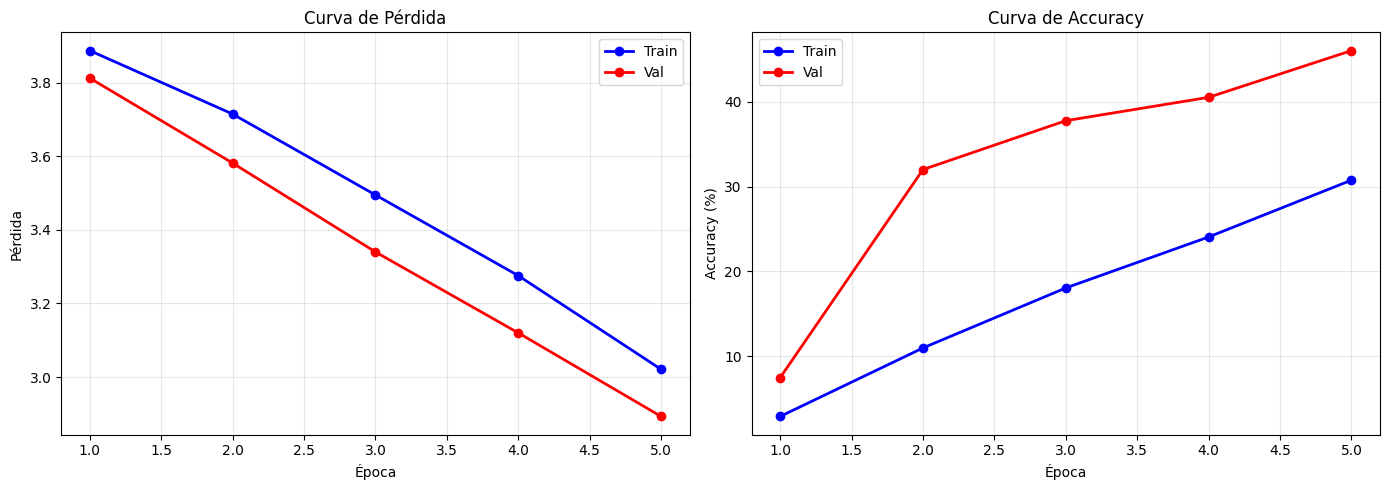

In [24]:
# ============================================================
# CURVAS DE APRENDIZAJE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epocas = range(1, len(historial['train_loss']) + 1)

# Pérdida
axes[0].plot(epocas, historial['train_loss'], 'b-o', label='Train', linewidth=2)
axes[0].plot(epocas, historial['val_loss'], 'r-o', label='Val', linewidth=2)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Pérdida')
axes[0].set_title('Curva de Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epocas, [a*100 for a in historial['train_acc']], 'b-o', label='Train', linewidth=2)
axes[1].plot(epocas, [a*100 for a in historial['val_acc']], 'r-o', label='Val', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Curva de Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_aprendizaje.png', dpi=150)
plt.show()

---
## 12. Evaluación Final

In [25]:
# ============================================================
# CARGAR MEJOR MODELO Y EVALUAR
# ============================================================

modelo.load_state_dict(torch.load('mejor_modelo_esc50.pth'))
val_loss, val_acc, predicciones, etiquetas_reales = evaluar(modelo, val_loader, criterio, device)

print("📊 EVALUACIÓN FINAL")
print("="*50)
print(f"   Pérdida: {val_loss:.4f}")
print(f"   Accuracy: {val_acc*100:.2f}%")

📊 EVALUACIÓN FINAL
   Pérdida: 2.8928
   Accuracy: 46.00%


In [26]:
# ============================================================
# REPORTE DE CLASIFICACIÓN
# ============================================================

nombres_categorias = dataset_train.categorias

print("\n📋 REPORTE DE CLASIFICACIÓN:")
print("="*70)
print(classification_report(etiquetas_reales, predicciones, target_names=nombres_categorias, zero_division=0))


📋 REPORTE DE CLASIFICACIÓN:
                  precision    recall  f1-score   support

        airplane       0.11      0.12      0.12         8
       breathing       0.20      0.12      0.15         8
  brushing_teeth       0.71      0.62      0.67         8
     can_opening       0.75      0.38      0.50         8
        car_horn       1.00      0.12      0.22         8
             cat       0.50      0.25      0.33         8
        chainsaw       1.00      0.62      0.77         8
  chirping_birds       0.00      0.00      0.00         8
    church_bells       0.62      1.00      0.76         8
        clapping       0.25      0.12      0.17         8
     clock_alarm       0.67      0.75      0.71         8
      clock_tick       1.00      0.25      0.40         8
        coughing       0.00      0.00      0.00         8
             cow       0.57      0.50      0.53         8
  crackling_fire       0.33      0.38      0.35         8
        crickets       0.56      0.62     

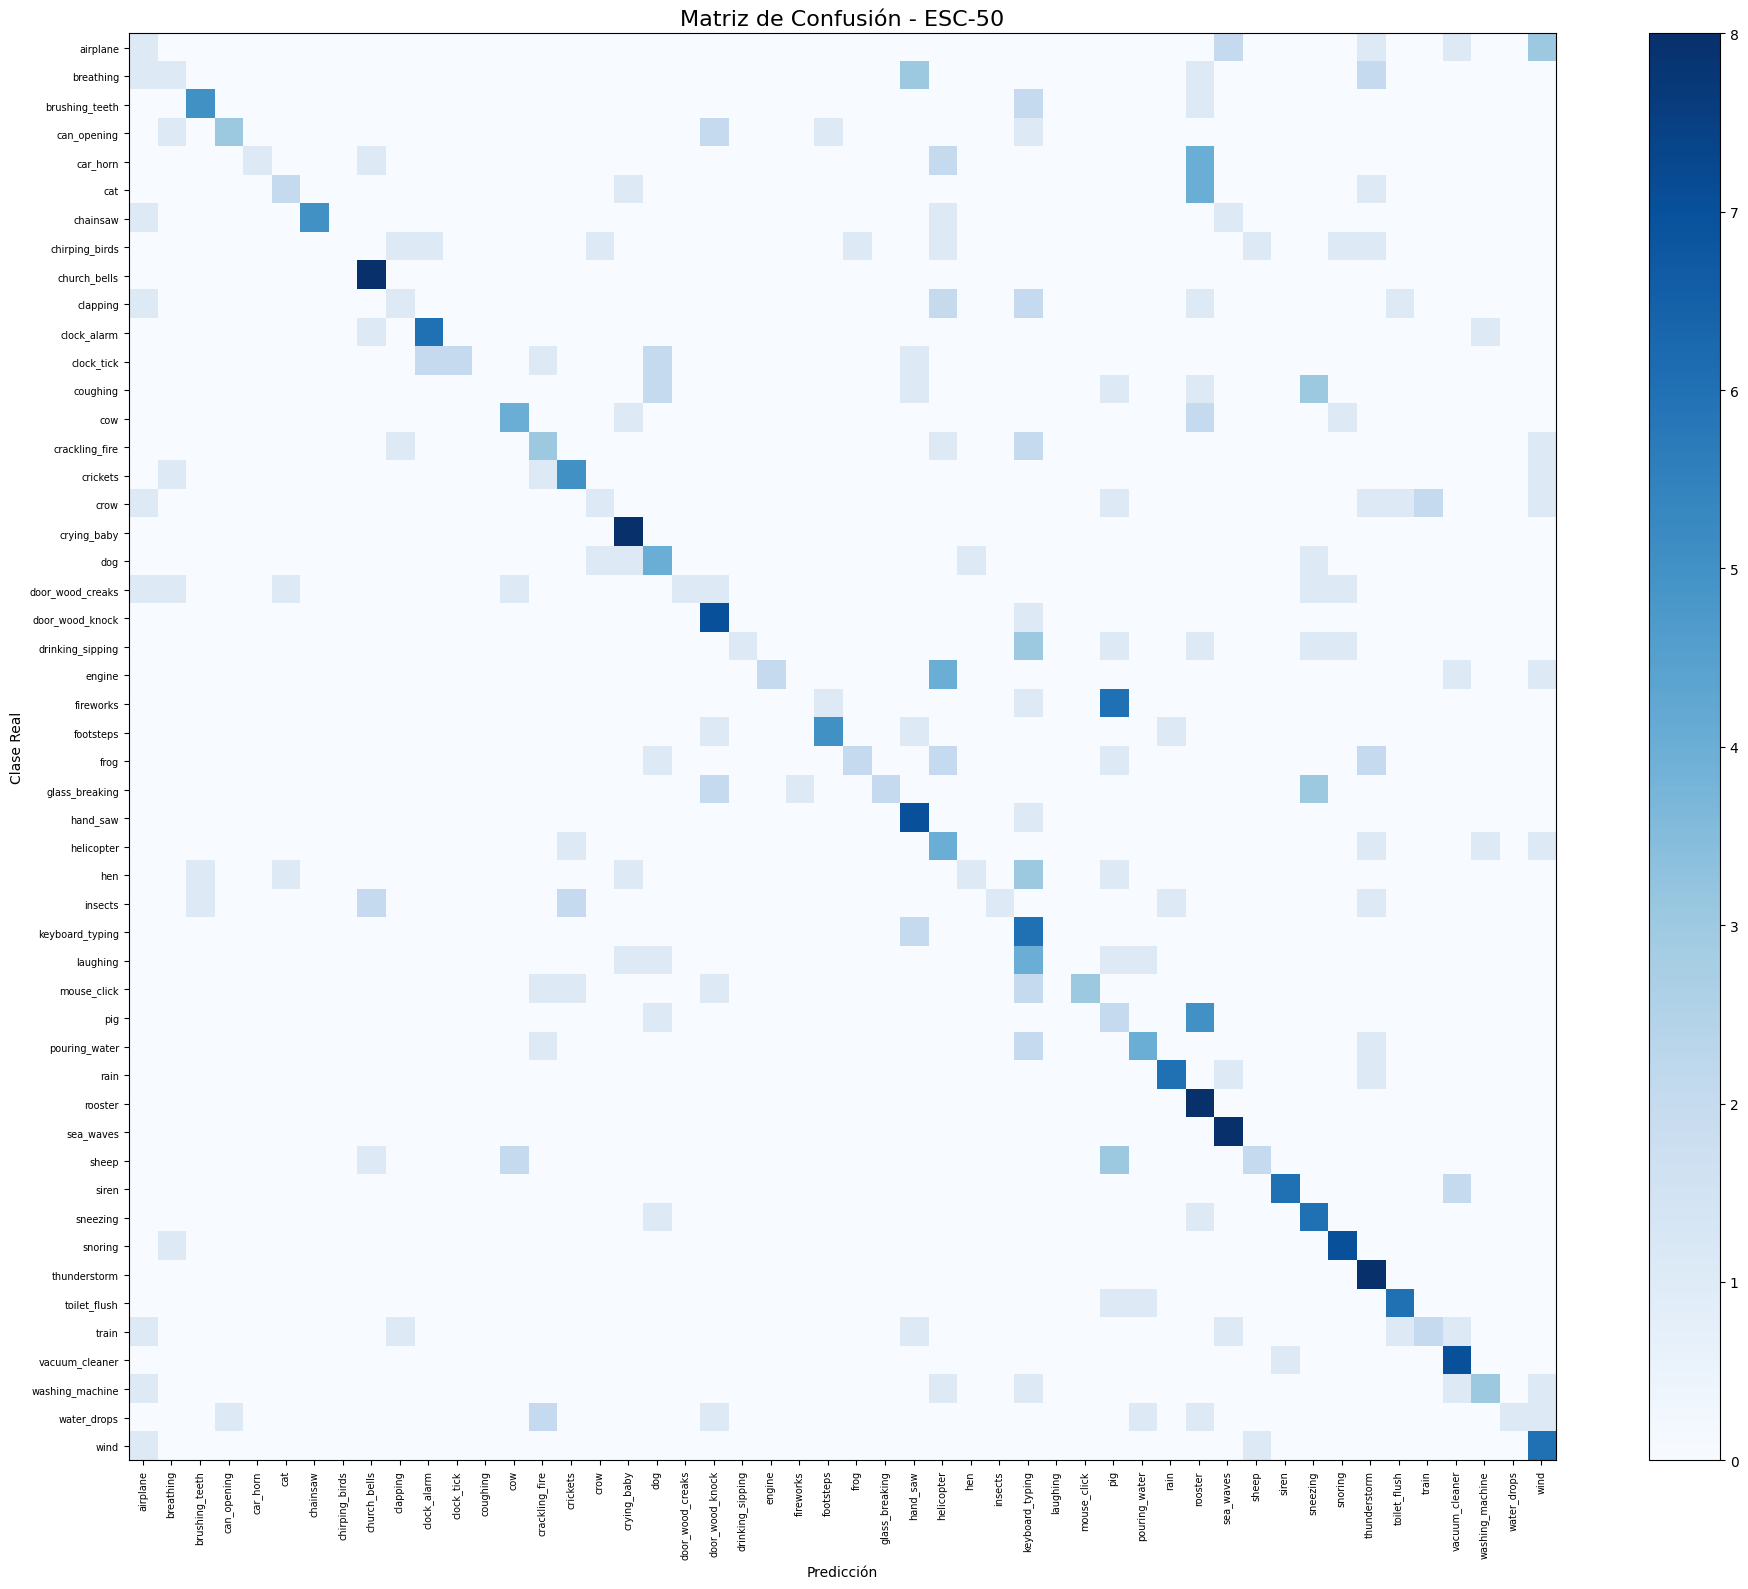

In [27]:
# ============================================================
# MATRIZ DE CONFUSIÓN
# ============================================================

cm = confusion_matrix(etiquetas_reales, predicciones)

plt.figure(figsize=(20, 16))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de Confusión - ESC-50', fontsize=16)
plt.colorbar()

tick_marks = np.arange(len(nombres_categorias))
plt.xticks(tick_marks, nombres_categorias, rotation=90, fontsize=7)
plt.yticks(tick_marks, nombres_categorias, fontsize=7)
plt.xlabel('Predicción')
plt.ylabel('Clase Real')

plt.tight_layout()
plt.savefig('matriz_confusion.png', dpi=150)
plt.show()

---
## 13. Predicción de Audio Individual

In [28]:
# ============================================================
# FUNCIÓN PARA PREDECIR UN AUDIO
# ============================================================

def predecir_audio(ruta_audio, modelo, categorias, device):
    """Predice la categoría de un archivo de audio."""
    modelo.eval()
    
    mel_spec = audio_a_mel_espectrograma(ruta_audio)
    mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min() + 1e-8)
    mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
    mel_spec = mel_spec.unsqueeze(0).repeat(3, 1, 1)
    mel_spec = transformaciones(mel_spec)
    mel_spec = mel_spec.unsqueeze(0).to(device)
    
    with torch.no_grad():
        salida = modelo(mel_spec)
        probabilidades = torch.nn.functional.softmax(salida, dim=1)
        top5_prob, top5_idx = torch.topk(probabilidades, 5)
    
    top5 = {categorias[top5_idx[0][i].item()]: top5_prob[0][i].item() for i in range(5)}
    return list(top5.keys())[0], list(top5.values())[0], top5

print("✅ Función de predicción lista")

✅ Función de predicción lista


In [29]:
# ============================================================
# DEMOSTRACIÓN
# ============================================================

ejemplos_demo = df_val.sample(5, random_state=42)

print("🎵 DEMOSTRACIÓN DE PREDICCIONES")
print("="*60)

for _, fila in ejemplos_demo.iterrows():
    ruta = os.path.join(AUDIO_DIR, fila['filename'])
    categoria_real = fila['category']
    
    prediccion, confianza, top5 = predecir_audio(ruta, modelo, nombres_categorias, device)
    acierto = "✅" if prediccion == categoria_real else "❌"
    
    print(f"\n📁 {fila['filename']}")
    print(f"   Real: {categoria_real}")
    print(f"   Pred: {prediccion} ({confianza*100:.1f}%) {acierto}")

🎵 DEMOSTRACIÓN DE PREDICCIONES

📁 5-213836-C-9.wav
   Real: crow
   Pred: train (9.7%) ❌

📁 5-233607-A-39.wav
   Real: glass_breaking
   Pred: sneezing (9.0%) ❌

📁 5-160614-C-48.wav
   Real: fireworks
   Pred: pig (5.5%) ❌

📁 5-213836-D-9.wav
   Real: crow
   Pred: toilet_flush (5.6%) ❌

📁 5-188796-A-45.wav
   Real: train
   Pred: clapping (6.4%) ❌


---
## 14. Guardar Modelo Final

In [30]:
# ============================================================
# GUARDAR CHECKPOINT COMPLETO
# ============================================================

checkpoint = {
    'modelo_state_dict': modelo.state_dict(),
    'categorias': nombres_categorias,
    'accuracy': mejor_accuracy,
    'historial': historial
}

torch.save(checkpoint, 'modelo_esc50_completo.pth')

print("💾 MODELO GUARDADO")
print("="*50)
print(f"   Archivo: modelo_esc50_completo.pth")
print(f"   Accuracy: {mejor_accuracy*100:.2f}%")

💾 MODELO GUARDADO
   Archivo: modelo_esc50_completo.pth
   Accuracy: 46.00%


In [31]:
# ============================================================
# RESUMEN FINAL
# ============================================================

print("\n" + "="*60)
print("🎉 ¡PRÁCTICA COMPLETADA!")
print("="*60)
print(f"\n📊 Dataset: ESC-50 ({len(df)} audios, 50 clases)")
print(f"🧠 Modelo: ResNet-50 + Transfer Learning")
print(f"🎯 Accuracy: {mejor_accuracy*100:.2f}%")
print(f"\n📁 Archivos generados:")
print(f"   • mejor_modelo_esc50.pth")
print(f"   • modelo_esc50_completo.pth")
print(f"   • curvas_aprendizaje.png")
print(f"   • matriz_confusion.png")
print("="*60)


🎉 ¡PRÁCTICA COMPLETADA!

📊 Dataset: ESC-50 (2000 audios, 50 clases)
🧠 Modelo: ResNet-50 + Transfer Learning
🎯 Accuracy: 46.00%

📁 Archivos generados:
   • mejor_modelo_esc50.pth
   • modelo_esc50_completo.pth
   • curvas_aprendizaje.png
   • matriz_confusion.png
